In [1]:
import cv2

import imageio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap

ModuleNotFoundError: No module named 'imageio'

In [2]:
data_dir = '/Users/linechina/python-test/chinese-ausweis-viewer/chinese_ausweis_viewer/data/train'
mask_img = imageio.imread(f'{data_dir}/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)
original_mask = np.array(mask_img, dtype=np.uint8)

card_img = imageio.imread(f'{data_dir}/original_sample_1000.jpg', pilmode="RGB")
original_card = np.array(card_img, dtype=np.uint8)

NameError: name 'imageio' is not defined

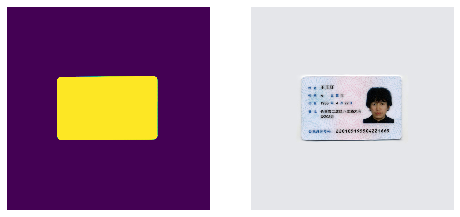

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_axis_off()
axes[0].imshow(mask_img);
axes[1].set_axis_off()
axes[1].imshow(card_img);

In [4]:
def resize_to_256(nd_array):
    im = Image.fromarray(nd_array)
    width, height = im.size
    min_size = min(width, height)
    left = (width - min_size) / 2
    top = (height - min_size) / 2
    right = (width + min_size) / 2
    bottom = (height + min_size) / 2
    im = im.crop((left, top, right, bottom))
    im = im.resize((256, 256), Image.ANTIALIAS)
    return np.array(im)

In [5]:
affine_aug = iaa.Affine(rotate=20, mode='wrap')

rotated_mask = affine_aug.augment_image(original_mask)
rotated_card = affine_aug.augment_image(original_card)

rotated_mask_256 = resize_to_256(rotated_mask)
rotated_card_256 = resize_to_256(rotated_card)

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_axis_off()
axes[0].imshow(rotated_mask_256);
axes[1].set_axis_off()
axes[1].imshow(rotated_card_256);

In [7]:
def _get_contour(mask):
    _, threshold = cv2.threshold(mask, 240, 255, cv2.THRESH_BINARY)
    _, contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours[0]


def get_bound_box(mask):
    cnt = _get_contour(mask)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    # np.int0(box)
    return box

def get_angle_of_bound_box(mask):
    cnt = _get_contour(mask)
    rect = cv2.minAreaRect(cnt)
    angl_ = rect[2]
    angle = 90 + angl_ if abs(angl_) > 45 else angl_
    return angle
  

def rotate_mask_on_angle(mask, angle):
    affine_aug = iaa.Affine(rotate=-angle, mode='wrap')
    return affine_aug.augment_image(mask)

  
def angle_and_bound_box_after_rotate(mask):
    angle = get_angle_of_bound_box(mask)
    rotated_mask = rotate_mask_on_angle(mask, angle)
    box = get_bound_box(rotated_mask)
    coef = mask.shape[0]
    return {
        'angle': angle,
        'mask': rotated_mask,
        'box': box,
        'rel_box': box / coef,
    }

In [8]:
angle = get_angle_of_bound_box(rotated_mask_256)
reversed_mask_256 = rotate_mask_on_angle(rotated_mask_256, angle)
reversed_card = rotate_mask_on_angle(rotated_card, angle)
box = get_bound_box(reversed_mask_256)
orig_size_box = box * (rotated_card.shape[0] / 256.0)
orig_size_box_int = np.int0(orig_size_box)


In [9]:
orig_size_box_int

array([[250, 648],
       [250, 343],
       [738, 343],
       [738, 648]])

In [10]:
reversed_card_with_box = cv2.drawContours(reversed_card.copy(), [orig_size_box_int], 0, (200,0,0), 3)
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.set_axis_off()
axes.imshow(reversed_card_with_box);

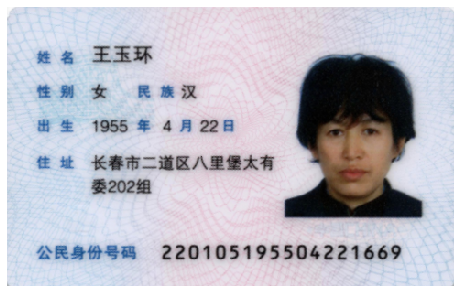

In [11]:
a1, a2 = orig_size_box_int.min(axis=0), orig_size_box_int.max(axis=0)
reversed_croped_card = reversed_card[a1[1]:a2[1], a1[0]:a2[0]]

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.set_axis_off()
axes.imshow(reversed_croped_card);

In [12]:
def pipeline(rotated_mask_256, rotated_card):
    # rotate orig img
    angle = get_angle_of_bound_box(rotated_mask_256)
    reversed_mask_256 = rotate_mask_on_angle(rotated_mask_256, angle)
    reversed_card = rotate_mask_on_angle(rotated_card, angle)
    
    # find bound box
    box = get_bound_box(reversed_mask_256)
    orig_size_box = box * (rotated_card.shape[0] / 256.0)
    orig_size_box_int = np.int0(orig_size_box)
    
    # crop
    a1, a2 = orig_size_box_int.min(axis=0), orig_size_box_int.max(axis=0)
    reversed_croped_card = reversed_card[a1[1]:a2[1], a1[0]:a2[0]]
    
    return reversed_croped_card

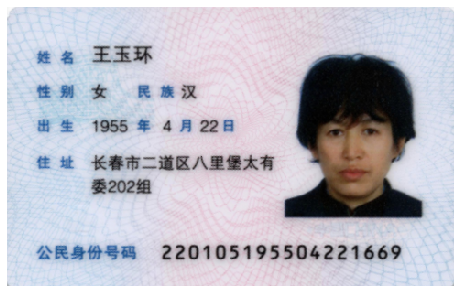

In [13]:
reversed_croped_card = pipeline(rotated_mask_256, rotated_card)

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.set_axis_off()
axes.imshow(reversed_croped_card);

In [14]:
reversed_croped_card.shape[1] / reversed_croped_card.shape[0]

1.6

In [15]:
df = pd.read_csv(f'{data_dir}/resident_identity_card_mapping.csv')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
x0        17 non-null float64
y0        17 non-null float64
size_x    17 non-null float64
size_y    17 non-null float64
dtypes: float64(4)
memory usage: 672.0 bytes


In [17]:
boxes = list()
for i in range(df.shape[0]):
    x0 = df.iloc[i][0]
    y0 = df.iloc[i][1]  # + 0.02
    sx = df.iloc[i][2]
    sy = df.iloc[i][3]
    
    box = np.array([
        [x0, y0 + sy],
        [x0, y0],
        [x0 + sx, y0],
        [x0 + sx, y0 + sy],
    ])
    boxes.append(box)

In [18]:
boxes[0]

array([[0.04965243, 0.22870662],
       [0.04965243, 0.1340694 ],
       [0.16881827, 0.1340694 ],
       [0.16881827, 0.22870662]])

In [19]:
canvas = reversed_croped_card.copy()
coef = np.array([canvas.shape[1] * 1.0, canvas.shape[0] * 1.0])

box_coords = []
for box in boxes:
    box1 = box * coef
    box_coords.append(np.int0(box1))
    canvas = cv2.drawContours(canvas, [np.int0(box1)], 0, (200,0,0), 1)

fig, axes = plt.subplots(1, 1, figsize=(16, 8))
axes.set_axis_off()
axes.imshow(canvas);

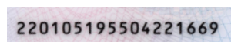

In [20]:
box_int = box_coords[-1]

a1, a2 = box_int.min(axis=0), box_int.max(axis=0)
number_img = reversed_croped_card[a1[1]:a2[1], a1[0]:a2[0]]

fig, axes = plt.subplots(1, 1, figsize=(4, 2 ))
axes.set_axis_off()
axes.imshow(number_img);

In [21]:
import pytesseract
from PIL import Image
from difflib import SequenceMatcher

In [23]:

im = Image.fromarray(number_img)
predict_val = pytesseract.image_to_string(im, lang='eng')
predict_val = predict_val.replace(' ', '')
predict_val

'220105195504221669'

In [24]:
box_int = box_coords[9]

a1, a2 = box_int.min(axis=0), box_int.max(axis=0)
name_img = reversed_croped_card[a1[1]:a2[1], a1[0]:a2[0]]

fig, axes = plt.subplots(1, 1, figsize=(4, 2 ))
axes.set_axis_off()
axes.imshow(name_img);

In [25]:
prepare_seq = iaa.Sequential([
    iaa.Grayscale(alpha=1.0),
    iaa.Multiply(1.2)
])

gray_name_img = prepare_seq.augment_image(name_img)
fig, axes = plt.subplots(1, 1, figsize=(4, 2 ))
axes.set_axis_off()
axes.imshow(gray_name_img);

In [26]:
def extract_text(img_ndarray):
    pil_img = Image.fromarray(img_ndarray)
    sim_text = pytesseract.image_to_string(pil_img, lang='chi_sim')
    tra_text = pytesseract.image_to_string(pil_img, lang='chi_tra')
    return sim_text, tra_text

In [28]:
extract_text(gray_name_img)

('王玉环', '王玉環')

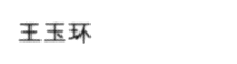

In [29]:

gray_name_img_brighter = iaa.Multiply(1.2).augment_image(gray_name_img)

fig, axes = plt.subplots(1, 1, figsize=(4, 2 ))
axes.set_axis_off()
axes.imshow(gray_name_img_brighter);

In [30]:
extract_text(gray_name_img_brighter)

('王玉环', '王玉環')

In [31]:
labels = [
    'name_label', 
    'sex_label', 
    'nationality_label', 
    'birthday_label', 
    'year_label', 
    'month_label', 
    'day_label', 
    'address_label', 
    'id_number_label', 
    'name_value', 
    'sex_value', 
    'nationality_value', 
    'year_value', 
    'month_value', 
    'day_value', 
    'address_value', 
    'id_number_value', 
]

In [32]:
len(box_coords)

17

In [33]:
len(labels)

17

In [34]:
def crop_img_part_by_box(img, box):
    a1, a2 = box.min(axis=0), box.max(axis=0)
    return img[a1[1]:a2[1], a1[0]:a2[0]]

def extract_text(img):
    pillow_img = Image.fromarray(img)
    return pytesseract.image_to_string(pillow_img, lang='chi_sim', config='--psm 1 --oem 1')

def grayscale(img):
    return iaa.Grayscale(alpha=1.0).augment_image(img)

def prepare_img_part(img):
    prepare_seq = iaa.Sequential([
        iaa.Multiply(1.05),
        iaa.ContrastNormalization(1.05),
        iaa.Sharpen(alpha=0.04, lightness=1.05)
    ])
    return prepare_seq.augment_image(img)

In [36]:
image_data = {}
image_parts = {}
prepared_image_parts = {}
for i, box in enumerate(box_coords):
    title = labels[i]
    img_part = crop_img_part_by_box(reversed_croped_card, box)
    gray_img_part = grayscale(img_part)
    image_parts[title] = gray_img_part
    image_data[title] = ''
    k = 6  # 6
    while k > 0:
        k -= 1
        text = extract_text(gray_img_part)
        if text:
            image_data[title] = text
            image_parts[title] = gray_img_part
            break
        else:
            gray_img_part = prepare_img_part(gray_img_part)
            prepared_image_parts[title] = gray_img_part
image_data

{'name_label': '',
 'sex_label': '性 别',
 'nationality_label': '',
 'birthday_label': '埋 生',
 'year_label': '',
 'month_label': '',
 'day_label': '',
 'address_label': '',
 'id_number_label': '公民身份号码',
 'name_value': '王玉环',
 'sex_value': '',
 'nationality_value': '',
 'year_value': '1955',
 'month_value': '',
 'day_value': '',
 'address_value': '长春市二道区八里堡太有\n委202组',
 'id_number_value': '220105195504221669'}

In [37]:
image_data

{'name_label': '',
 'sex_label': '性 别',
 'nationality_label': '',
 'birthday_label': '埋 生',
 'year_label': '',
 'month_label': '',
 'day_label': '',
 'address_label': '',
 'id_number_label': '公民身份号码',
 'name_value': '王玉环',
 'sex_value': '',
 'nationality_value': '',
 'year_value': '1955',
 'month_value': '',
 'day_value': '',
 'address_value': '长春市二道区八里堡太有\n委202组',
 'id_number_value': '220105195504221669'}

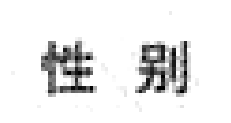

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(4, 2 ))
axes.set_axis_off()
axes.imshow(prepared_image_parts['sex_label']);

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.set_axis_off()
axes.imshow(image_parts['address_value']);

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
axes[0].set_axis_off()
axes[0].imshow(prepared_image_parts['year_value']);
axes[1].set_axis_off()
axes[1].imshow(prepared_image_parts['month_value']);
axes[2].set_axis_off()
axes[2].imshow(prepared_image_parts['day_value']);

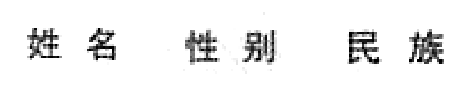

In [41]:

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
axes[0].set_axis_off()
axes[0].imshow(prepared_image_parts['name_label']);
axes[1].set_axis_off()
axes[1].imshow(prepared_image_parts['sex_label']);
axes[2].set_axis_off()
axes[2].imshow(prepared_image_parts['nationality_label']);

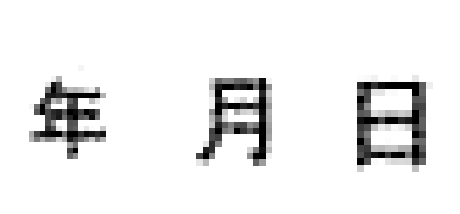

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
axes[0].set_axis_off()
axes[0].imshow(prepared_image_parts['year_label']);
axes[1].set_axis_off()
axes[1].imshow(prepared_image_parts['month_label']);
axes[2].set_axis_off()
axes[2].imshow(prepared_image_parts['day_label']);

In [43]:
extract_text(prepared_image_parts['month_value'])

''

In [44]:
pillow_img = Image.fromarray(prepared_image_parts['month_value'])
pytesseract.image_to_string(pillow_img, lang='eng')  # , config='--psm 1 --oem 1'

''

In [45]:
def extract_data(reversed_croped_card):
    image_data = {}
    for i, box in enumerate(box_coords):
        title = labels[i]
        img_part = crop_img_part_by_box(reversed_croped_card, box)
        gray_img_part = grayscale(img_part)
        image_data[title] = ''
        k = 6
        while k > 0:
            k -= 1
            text = extract_text(gray_img_part)
            if text:
                image_data[title] = text
                break
            else:
                gray_img_part = prepare_img_part(gray_img_part)
    return image_data

In [46]:
extract_data(reversed_croped_card)

{'name_label': '',
 'sex_label': '性 别',
 'nationality_label': '',
 'birthday_label': '埋 生',
 'year_label': '',
 'month_label': '',
 'day_label': '',
 'address_label': '',
 'id_number_label': '公民身份号码',
 'name_value': '王玉环',
 'sex_value': '',
 'nationality_value': '',
 'year_value': '1955',
 'month_value': '',
 'day_value': '',
 'address_value': '长春市二道区八里堡太有\n委202组',
 'id_number_value': '220105195504221669'}

In [47]:
# load original images
mask_img = imageio.imread(f'{data_dir}/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)
original_mask = np.array(mask_img, dtype=np.uint8)

card_img = imageio.imread(f'{data_dir}/original_sample_1000.jpg', pilmode="RGB")
original_card = np.array(card_img, dtype=np.uint8)

# simulate wild worl (rotate to 20)
affine_aug = iaa.Affine(rotate=20, mode='wrap')

rotated_mask = affine_aug.augment_image(original_mask)
rotated_card = affine_aug.augment_image(original_card)

rotated_mask_256 = resize_to_256(rotated_mask)

# get card image by mask_256
reversed_croped_card = pipeline(rotated_mask_256, rotated_card)

# extract text data from card image
data = extract_data(reversed_croped_card)

In [48]:
data

{'name_label': '',
 'sex_label': '性 别',
 'nationality_label': '',
 'birthday_label': '埋 生',
 'year_label': '',
 'month_label': '',
 'day_label': '',
 'address_label': '',
 'id_number_label': '公民身份号码',
 'name_value': '王玉环',
 'sex_value': '',
 'nationality_value': '',
 'year_value': '1955',
 'month_value': '',
 'day_value': '',
 'address_value': '长春市二道区八里堡太有\n委202组',
 'id_number_value': '220105195504221669'}